### Initiate Environment

In [17]:
using Pkg
Pkg.activate(".")

using Revise
using TitanicClassifier
using CSV
using DataFrames
using Statistics
using Plots

  Activating project at `~/CTU/SEM_5/JUL/TitanicClassifier/examples`


### Data Analysis

In [18]:
data = CSV.read("../data/train.csv", DataFrame);

In [19]:
train = CSV.read("../data/train.csv", DataFrame);
select!(train, Not("Survived"));
test = CSV.read("../data/test.csv", DataFrame);
merged = vcat(train, test);
select!(merged, Not("PassengerId"));
first(merged, 5)

Row,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,Int64,String,String7,Float64?,Int64,Int64,String31,Float64?,String15?,String1?
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,missing,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,missing,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,missing,S


In order to apply any machine learning algorithm, we need to transform the data into numeric values. I've decided to leave 
column Pclass, SibSp, Parch, and Fare unchanged, since they're already numeric and don't require further transformation.

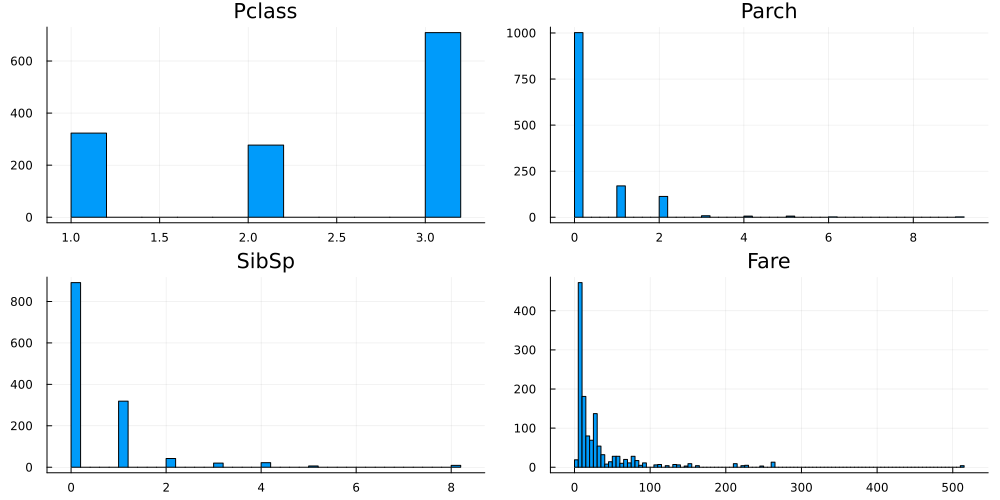

In [100]:
temp = [merged[!, "Pclass"], merged[!, "Parch"], merged[!, "SibSp"], merged[!, "Fare"]]

histogram(temp, layout=4, size=(1000,500), legend=false, visible=true, title=["Pclass" "Parch" "SibSp" "Fare"])

In the histograms above we can see the value distributions of Pclass, SibSp, Parch, and Fare columns.

In [94]:
uq_name = nrow(combine(groupby(merged, "Name"), nrow => :count))
uq_ticket = nrow(combine(groupby(merged, "Ticket"), nrow => :count))
uq_cabin = nrow(combine(groupby(merged, "Cabin"), nrow => :count))
print("Unique name count ", uq_name, "\nUnique ticket count ", uq_ticket, "\nUnique cabin count ", uq_cabin)

Unique name count 1307
Unique ticket count 929
Unique cabin count 187

 Since columns Sex, and Embarked are non numeric, yet categorical features, I've assigned their values integers 1 to n, where n is the number of categories for the respective columns. Columns Name, Ticket, and Cabin have to undergo more sophisticated transformation, since their non-missing values are mostly unique as we can see from the results above, and therefore they don't generalise well. From the Name feature I've decided to use only the person's title, since that's the infromation easiest extracted from the name (I've also thought about extracting person's nationality from their name, but that's much harder to do), which I then again transform into numeric categorical feature. Similarly I extract the deck from the Cabin column, and transform it into a numeric feature. Lastly I use the ticket number extracted from the Ticket column, which I then sort and the feature becomes the index of the ticket number in this sorted array.

In [95]:
incomplete_cols = Dict()

for row in eachrow(merged)
    for name in names(merged)
        if(ismissing(row[name]))
            incomplete_cols[name] = get!(incomplete_cols, name, 0) + 1
        end
    end
end

for entry in incomplete_cols
    print("Missing ", entry[2], " out of ", nrow(merged), " entries (", round(entry[2]/nrow(merged); sigdigits=2), "%) for column ", entry[1], "\n")
end

Missing 1 out of 1309 entries (0.00076%) for column Fare
Missing 263 out of 1309 entries (0.2%) for column Age
Missing 2 out of 1309 entries (0.0015%) for column Embarked
Missing 1014 out of 1309 entries (0.77%) for column Cabin


Moreover we can see that there are some values which are missing in the dataset. We need to fill columns with missing data with data in order for our model to be able to use these columns. The number of missing entries of the Cabin feature
is great and there is no clear method to impute the missing data - it might be possible to infer the cabin data from ticket 
and embarked features, however it's not clear how. I chose just to introduce an unknown token for the missing Cabin entries, since one of the sources for the Cabin data is the recollection of survivors, it seems that unknown token holds information for survival inference. On the other hand because the amount of missing data for Fare and Embarked is low, I impute the missing data simply with median for Fare (as it is resistant outliers), and the most common value for Embarked. Age feature I will impute from features which correlate with Age the most.

### Data Preprocessing

In [96]:
freq = title_frequencies(merged)

Dict{Any, Any} with 18 entries:
  "Jonkheer"     => 1
  "Don"          => 1
  "the Countess" => 1
  "Master"       => 61
  "Miss"         => 260
  "Capt"         => 1
  "Mrs"          => 197
  "Rev"          => 8
  "Major"        => 2
  "Mr"           => 757
  "Mme"          => 1
  "Mlle"         => 2
  "Col"          => 4
  "Dona"         => 1
  "Lady"         => 1
  "Sir"          => 1
  "Ms"           => 2
  "Dr"           => 8

Above we can see all the titles from the dataset and their frequencies. Closer inspection of the titles reveals that a lot of them bear similarities with one another and their holders would be presumably treated the same way on the Titanic, therefore in an attempt to generalise these titles, I've created the following replacement rules.

In [98]:
# format: replace "Dr", "Rev", "Col", "Major", "Capt" with "Officer" 
replacement_rules = [[["Dr", "Rev", "Col", "Major", "Capt"], "Officer"],
                 [["Jonkheer", "Countess", "Sir", "Lady", "Don", "Dona"], "Royalty"], 
                 [["Mlle"], "Miss"], [["Ms"], "Miss"], [["Mme"],"Mrs"]];

In [112]:
title_tokens = Dict{String, Integer}()

i = 0

replace_rules = [[["Dr", "Rev", "Col", "Major", "Capt"], "Officer"],
[["Jonkheer", "Countess", "Sir", "Lady", "Don"], "Royalty"], 
[["Mlle"], "Miss"], [["Ms"], "Miss"], [["Mme"],"Mrs"]]

for (title, value) in freq
    if !haskey(title_tokens, get_title_token(title, replace_rules))
        title_tokens[get_title_token(title, replace_rules)] = i
        i+=1
    end
end

print(title_tokens)

Dict{String, Integer}("Miss" => 2, "Dona" => 6, "Master" => 1, "Officer" => 3, "Royalty" => 0, "Mrs" => 4, "Mr" => 5)

Creating integer tokens representing the various title categories described above.

In [105]:
extract_deck_from_cabin(cabin) = cabin[1]

decks = Dict{Char, Integer}()

id = 1
for row in eachrow(data)
    if !ismissing(row["Cabin"]) && !haskey(decks, extract_deck_from_cabin(row["Cabin"]))
        decks[extract_deck_from_cabin(row["Cabin"])] = id
        id+=1
    end
end
decks['U'] = id

print(decks)

Dict{Char, Integer}('B' => 6, 'U' => 9, 'D' => 4, 'A' => 5, 'E' => 2, 'G' => 3, 'T' => 8, 'F' => 7, 'C' => 1)

Here we can see the letters signifying the decks of the Titanic. U being the unknown deck token.

In [106]:
embarks = Dict{String1, Integer}()

id = 1
for row in eachrow(data)
    if !ismissing(row["Embarked"]) && !haskey(embarks, row["Embarked"])
        embarks[row["Embarked"]] = id
        id+=1
    end
end
print(embarks)

Dict{String1, Integer}(

String1("Q") => 3, String1("S") => 1, String1("C") => 2)

Here we can see the integers standing for the different docks from which the passengers embarked on the Titanic.

In [108]:
tickets = Set()

function extract_ticket_num(ticket) 
    temp = split(ticket, " ")
    if (length(temp) == 1 && temp[1]=="LINE")
        return -1
    else 
        return parse(Int64, last(temp))
    end
end

for row in eachrow(merged)
    push!(tickets, extract_ticket_num(row["Ticket"]))
end

sorted_nums = sort(collect(tickets))

ticket_idx = Dict{Integer, Integer}()
for i in 1:length(sorted_nums)
    ticket_idx[sorted_nums[i]] = i
end


Creating a dictionary of the ticket numbers and their sorted indices.

In [116]:
processed_data = copy(merged)

enumerate_sex(str) = str == "male" ? 0 : 1

transform!(processed_data, :Sex => ByRow(sex -> enumerate_sex(sex)) => :Sex)
transform!(processed_data, :Cabin => ByRow(cabin -> ismissing(cabin) ? decks['U'] : decks[extract_deck_from_cabin(cabin)]) => :Cabin)
transform!(processed_data, :Ticket => ByRow(ticket -> ticket_idx[extract_ticket_num(ticket)]) => :Ticket)
transform!(processed_data, :Embarked => ByRow(embarked -> ismissing(embarked) ? missing : embarks[embarked]) => :Embarked)
transform!(processed_data, :Name => ByRow(name -> title_tokens[get_title_token(name, replace_rules)]) => :Name)

print(first(processed_data, 5))


5×10 DataFrame
 Row │ Pclass  Name   Sex    Age       SibSp  Parch  Ticket  Fare      Cabin  Embarked 
     │ Int64   Int64  Int64  Float64?  Int64  Int64  Int64   Float64?  Int64  Int64?   
─────┼─────────────────────────────────────────────────────────────────────────────────
   1 │      3      5      0      22.0      1      0     299    7.25        9         1
   2 │      1      4      1      38.0      1      0     261   71.2833      1         2
   3 │      3      2      1      26.0      0      0     896    7.925       9         1
   4 │      1      4      1      35.0      1      0     464   53.1         1         1
   5 │      3      5      0      35.0      0      0     846    8.05        9         1

Applying all the techniques for creating numeric values out of the features.

### Imputing Missing Data

In [141]:
fare_median = median(skipmissing(processed_data[!, "Fare"]))
replace!(processed_data."Fare", missing => kek)


print(nrow(processed_data), "\n")
print(nrow(dropmissing(processed_data, "Fare")))

1309
1309

In [80]:

filtered = filter(missing_filter("Embarked"), filter(missing_filter("Age"), processed_data))

display(DataFrame(cor(Matrix(filtered)), ["Survived", "Pclass", "Title", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]))

Row,Survived,Pclass,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,-0.356462,-0.426484,0.536762,-0.0824459,-0.015523,0.0952653,-0.182137,0.2661,-0.279494,0.108517
2,-0.356462,1.0,0.0863682,-0.150826,-0.365902,0.0651871,0.0236661,0.371343,-0.552893,0.691132,-0.108502
3,-0.426484,0.0863682,1.0,-0.600639,0.386344,-0.315565,-0.274225,0.0310607,-0.149062,0.0578926,-0.137506
4,0.536762,-0.150826,-0.600639,1.0,-0.0990372,0.106296,0.249543,-0.0897378,0.182457,-0.135285,0.0971287
5,-0.0824459,-0.365902,0.386344,-0.0990372,1.0,-0.307351,-0.187896,-0.122777,0.0931425,-0.245705,0.0121857
6,-0.015523,0.0651871,-0.315565,0.106296,-0.307351,1.0,0.383338,0.0277467,0.13986,0.00548101,0.00402065
7,0.0952653,0.0236661,-0.274225,0.249543,-0.187896,0.383338,1.0,-0.0128203,0.206624,-0.0230722,-0.0140824
8,-0.182137,0.371343,0.0310607,-0.0897378,-0.122777,0.0277467,-0.0128203,1.0,-0.215444,0.227769,-0.155978
9,0.2661,-0.552893,-0.149062,0.182457,0.0931425,0.13986,0.206624,-0.215444,1.0,-0.458929,0.176859


Here we can see that Embarked feature doesn't correlate particularly strongly with any of our modified features, therefore I will impute it simply by replacing missing values with the most common value. On the other hand age correlates moderately strongly with
Title, Pclass, Sibsp and Cabin. Of these I will use Title and Pclass to impute Age since these are the two strongest correlated
features with Age.